In [5]:
%run FUNCIONES_GENERALES.ipynb

/home/khaosdev/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/khaosdev/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [39]:
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt

# skforecast
import skforecast
import pandas as pd
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from pmdarima import auto_arima 

import warnings
warnings.filterwarnings('once')

Ejemplos general:

In [1]:
fecha1='1/1/2012'

In [2]:
fecha2='1/1/2024'

In [3]:
fecha3='1/1/2026'

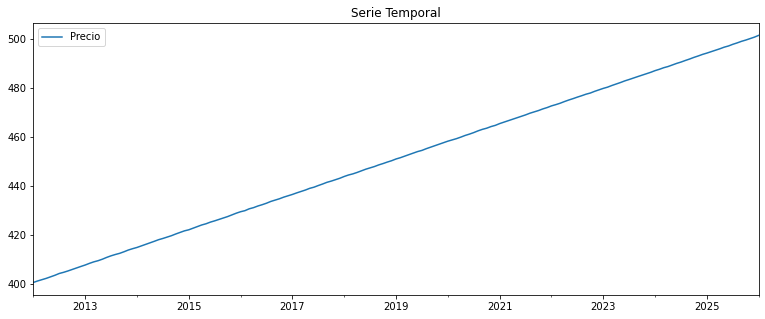

In [17]:
datos = crear_df_fin_tend_det(fecha1,fecha3,'MS',['Precio'],[400,0.6],1,0.2)

In [20]:
display(datos.head())

,Precio
2012-01-01,400.730725
2012-02-01,401.334968
2012-03-01,401.848744
2012-04-01,402.401003
2012-05-01,403.023553


In [43]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2024-01-01 23:59:59'
datos_train = datos.loc[:fin_train]
datos_test  = datos.loc[fin_train:]

BACKTESTING:

In [53]:
# Grid search
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=500
                            )
            )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None]
}

resultados_grid = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = datos['Precio'],
                        param_grid            = param_grid,
                        steps                 = 12,
                        refit                 = True,
                        metric                = 'mean_absolute_error',
                        initial_train_size    = len(datos_train),
                        fixed_train_size      = False,
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )

Number of models compared: 15.


params grid:   0%|          | 0/15 [00:00<?, ?it/s]

In [54]:
resultados_grid

,params,mean_absolute_error,order,seasonal_order,trend
14,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",0.048088,"(2, 1, 1)","(1, 1, 1, 12)",None
11,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",0.048448,"(1, 1, 1)","(1, 1, 1, 12)",None
5,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",0.048889,"(0, 1, 1)","(1, 1, 1, 12)",None
2,"{'order': (0, 1, 0), 'seasonal_order': (1, 1, ...",0.052133,"(0, 1, 0)","(1, 1, 1, 12)",None
8,"{'order': (1, 1, 0), 'seasonal_order': (1, 1, ...",0.052992,"(1, 1, 0)","(1, 1, 1, 12)",None
9,"{'order': (1, 1, 1), 'seasonal_order': (0, 0, ...",0.054251,"(1, 1, 1)","(0, 0, 0, 0)",None
12,"{'order': (2, 1, 1), 'seasonal_order': (0, 0, ...",0.060976,"(2, 1, 1)","(0, 0, 0, 0)",None
10,"{'order': (1, 1, 1), 'seasonal_order': (0, 1, ...",0.065325,"(1, 1, 1)","(0, 1, 0, 12)",None
13,"{'order': (2, 1, 1), 'seasonal_order': (0, 1, ...",0.065401,"(2, 1, 1)","(0, 1, 0, 12)",None
4,"{'order': (0, 1, 1), 'seasonal_order': (0, 1, ...",0.066096,"(0, 1, 1)","(0, 1, 0, 12)",None


In [45]:
# Auto arima: seleccion basada en AIC
# ==============================================================================
modelo = auto_arima(
            y                 = datos['Precio'],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1625.023, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2548.061, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=159.085, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-268.558, Time=0.56 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-278.786, Time=1.61 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-265.094, Time=1.76 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=inf, Time=1.16 se

In [51]:
# Predicciones de backtesting con el mejor modelo según el grid search
# ==============================================================================
forecaster = ForecasterSarimax( regressor=Sarimax(order=(2, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
                )

metrica_m1, predicciones_m1 = backtesting_sarimax(
                                        forecaster            = forecaster,
                                        y                     = datos['Precio'],
                                        initial_train_size    = len(datos.loc[:fin_val]),
                                        steps                 = 24,
                                        metric                = 'mean_absolute_error',
                                        refit                 = True,
                                        n_jobs                = "auto",
                                        suppress_warnings_fit = True,
                                        verbose               = False,
                                        show_progress         = True
                                    )

# Predicciones de backtesting con el mejor modelo según auto arima
# ==============================================================================
forecaster = ForecasterSarimax(
                    regressor=Sarimax(order=(2, 0, 0), seasonal_order=(1, 0, 1, 12), maxiter=500),
                )

metrica_m2, predicciones_m2 = backtesting_sarimax(
                                        forecaster            = forecaster,
                                        y                     = datos['Precio'],
                                        initial_train_size    = len(datos.loc[:fin_val]),
                                        steps                 = 12,
                                        metric                = 'mean_absolute_error',
                                        refit                 = True,
                                        n_jobs                = "auto",
                                        suppress_warnings_fit = True,
                                        verbose               = False,
                                        show_progress         = True
                                    )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


,mean_absolute_error
0,0.04875


Metric (mean_absolute_error) del modelo auto arima:


,mean_absolute_error
0,0.08414


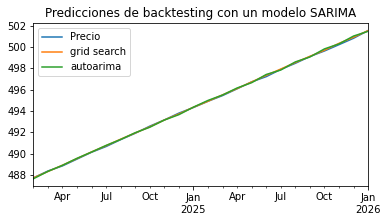

In [52]:
# Comparación de métricas
# ==============================================================================
print("Metrica (mean absolute error) del modelo grid search:")
display(metrica_m1)
print("Metric (mean_absolute_error) del modelo auto arima:")
display(metrica_m2)

fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_val:].plot(ax=ax, label='test')
predicciones_m1 = predicciones_m1.rename(columns={'pred': 'grid search'})
predicciones_m2 = predicciones_m2.rename(columns={'pred': 'autoarima'})
predicciones_m1.plot(ax=ax)
predicciones_m2.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend()